In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import time
import itertools
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
from sklearn.model_selection import train_test_split
os.getcwd()
os.chdir(r'C:\Users\Haneef Usmani\Desktop\STAT 303-2\Project')

In [3]:
flight = pd.read_csv('flights_clean.csv')

In [4]:
# split flight into train and test
train, test = train_test_split(flight, test_size=0.2)
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [6]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('(departure_delay)~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [7]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [8]:
models_best = backward_selection()

Processed  16 models on 15 predictors in 68.81499290466309 seconds.
Processed  15 models on 14 predictors in 56.42546534538269 seconds.
Processed  14 models on 13 predictors in 52.14179182052612 seconds.
Processed  13 models on 12 predictors in 43.30004858970642 seconds.
Processed  12 models on 11 predictors in 33.920105934143066 seconds.
Processed  11 models on 10 predictors in 39.47048544883728 seconds.
Processed  10 models on 9 predictors in 27.994214296340942 seconds.
Processed  9 models on 8 predictors in 21.299396276474 seconds.
Processed  8 models on 7 predictors in 16.88595151901245 seconds.
Processed  7 models on 6 predictors in 12.681800365447998 seconds.
Processed  6 models on 5 predictors in 9.235478401184082 seconds.
Processed  5 models on 4 predictors in 6.387692451477051 seconds.
Processed  4 models on 3 predictors in 4.12565803527832 seconds.
Processed  3 models on 2 predictors in 2.5801966190338135 seconds.
Processed  2 models on 1 predictors in 1.328359842300415 secon

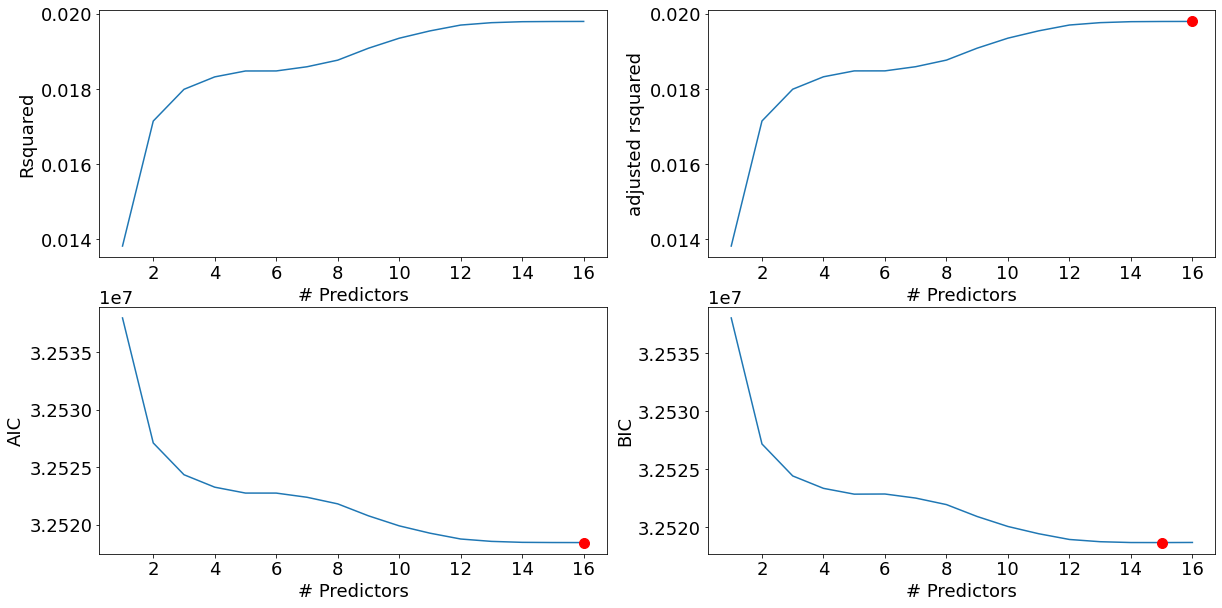

In [9]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [13]:
best_fwd_reg_model = models_best['model'][16]
best_fwd_reg_model.summary() # same result as forward selection

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4071.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:44:15   Log-Likelihood:            -1.6259e+07
No. Observations:             3225535   AIC:                         3.252e+07
Df Residuals:                 3225518   BIC:                         3.252e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -29.8504      1.040    -28.702      0.000     -31.889     -27.812
day                         1.1102      0.034     32.600      0.000       1.043       1.177
day_of_week                -0.3560      0.010    -33.986      0.000      -0.377      -0.335
destination_latitude       -0.0424      0.005     -8.525      0.000      -0.052      -0.033
destination_longitude       0.0285      0.002     15.531      0.000       0.025       0.032
distance                   -0.0018      0.000     -5.694      0.000      -0.002      -0.001
month                      33.9070      1.037     32.699      0.000      31.875      35.939
origin_latitude            -0.1277      0.005    -25.711      0.000      -0.137      -0.118
origin_longitude            0.0095      0.002      4.257      0.000       0.005       0.014
scheduled_arrival           0.0045   9.24e-05     48.629      0.000       0.004       0.005
scheduled_departure         0.0120   9.76e-05    123.350      0.000       0.012       0.012
scheduled_time              0.0232      0.003      9.045      0.000       0.018       0.028
taxi_in                     0.0893      0.004     24.031      0.000       0.082       0.097
taxi_out                    0.2205      0.002     92.488      0.000       0.216       0.225
day_of_year                -1.1165      0.034    -32.800      0.000      -1.183      -1.050
origin_temperature         -0.0451      0.002    -22.477      0.000      -0.049      -0.041
destination_temperature    -0.0047      0.002     -2.355      0.019      -0.009      -0.001
==============================================================================
Omnibus:                  4349087.685   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2039839534.607
Skew:                           7.504   Prob(JB):                         0.00
Kurtosis:                     125.280   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
pred_price = (best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.departure_delay)**2).mean())

37.41356160534415